Using device: cuda:0
Epoch 1, Train Loss: 0.5880369586689819, Test Loss: 0.02256208532971555
Epoch 2, Train Loss: 0.060702414882759896, Test Loss: 0.014100300601747787
Epoch 3, Train Loss: 0.038179901647832123, Test Loss: 0.004657810916702649
Epoch 4, Train Loss: 0.02624563712686781, Test Loss: 0.0020319338463164528
Epoch 5, Train Loss: 0.02058209128858101, Test Loss: 0.0012662284413542284
Epoch 6, Train Loss: 0.01707716277470031, Test Loss: 0.001687147943561411
Epoch 7, Train Loss: 0.01418447268586005, Test Loss: 0.0011012628329212773
Epoch 8, Train Loss: 0.012222357538919294, Test Loss: 0.0010266689417315728
Epoch 9, Train Loss: 0.010609472302659866, Test Loss: 0.0009836370873331204
Epoch 10, Train Loss: 0.009031879993516111, Test Loss: 0.000862919266880673
Epoch 11, Train Loss: 0.007959030854756072, Test Loss: 0.0008265904541001968
Epoch 12, Train Loss: 0.006827628693633503, Test Loss: 0.0008265852818645915
Epoch 13, Train Loss: 0.00616705743971491, Test Loss: 0.0010238362930098887


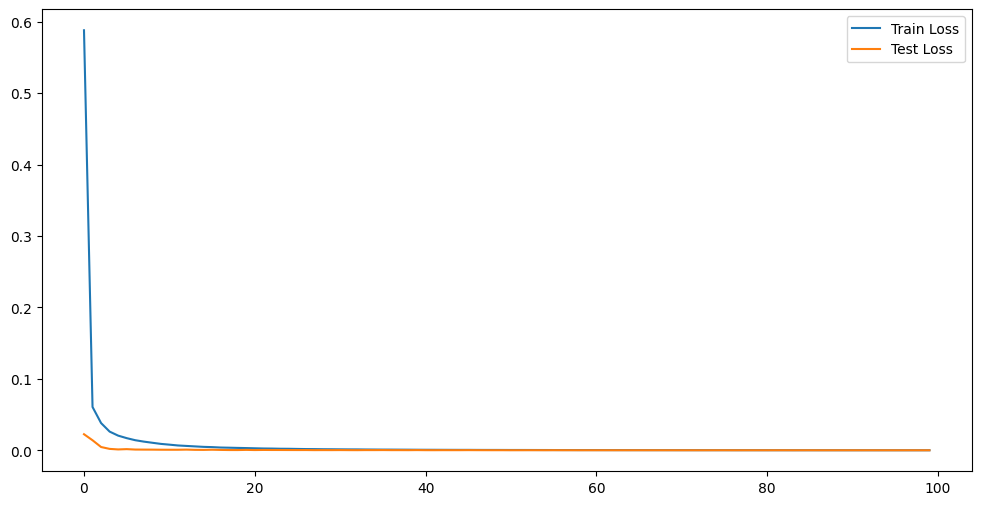

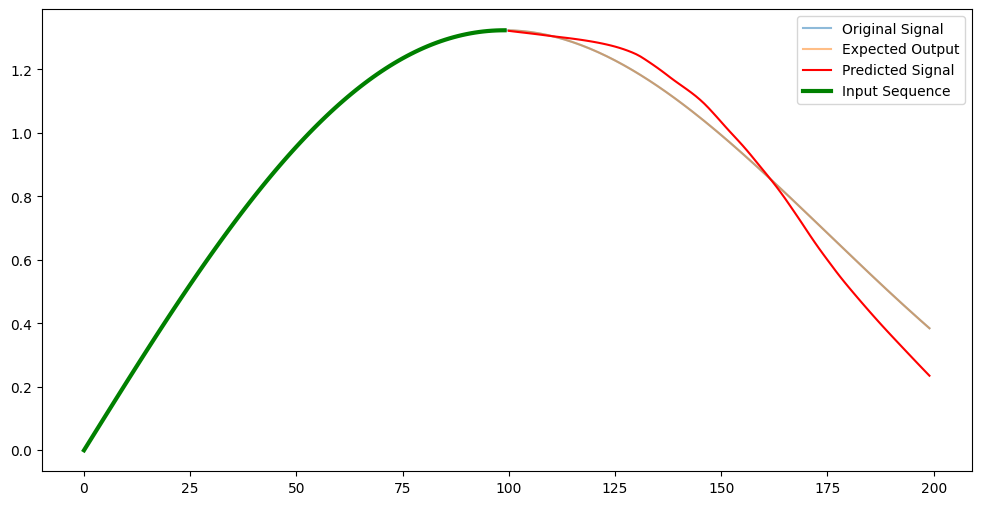

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the dataset class
class SignalDataset(Dataset):
    def __init__(self, signal, seq_len):
        self.signal = signal
        self.seq_len = seq_len

    def __len__(self):
        return len(self.signal) - self.seq_len

    def __getitem__(self, idx):
        seq = self.signal[idx:idx + self.seq_len]
        label = self.signal[idx + self.seq_len]
        return torch.tensor(seq, dtype=torch.float), torch.tensor(label, dtype=torch.float)

nr_train=10000
nr_test=1000
# Generate sample signals
train_signal = np.sin(np.arange(nr_train) * 0.01) + 0.5 * np.sin(np.arange(nr_train) * 0.02)
test_signal = np.sin(np.arange(nr_test) * 0.011) + 0.5 * np.sin(np.arange(nr_test) * 0.021)

# Create datasets and data loaders
train_dataset = SignalDataset(train_signal, seq_len=100)
train_data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = SignalDataset(test_signal, seq_len=100)
test_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_heads, num_layers):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(1, input_dim)  # Add embedding layer
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads, dim_feedforward=hidden_dim, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)  # Apply embedding layer
        x = self.encoder(x)
        x = x[:, -1, :]  # Take the last output
        x = self.fc(x)
        return x

# Initialize the model, optimizer, and loss function
input_dim = 8
model = TransformerModel(input_dim=input_dim, hidden_dim=128, output_dim=1, num_heads=2, num_layers=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()

# Train the model
train_losses = []
test_losses = []
plt.ion()  # Turn on interactive mode
plt.show(block=False)  # Show the plot without blocking
for epoch in range(100):
    model.train()
    train_loss = 0
    for batch in train_data_loader:
        seq, label = batch
        seq = seq.view(-1, 100, 1).to(device)
        label = label.view(-1, 1).to(device)
        output = model(seq)
        loss = loss_fn(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_data_loader)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch in test_data_loader:
            seq, label = batch
            seq = seq.view(-1, 100, 1).to(device)
            label = label.view(-1, 1).to(device)
            output = model(seq)
            loss = loss_fn(output, label)
            test_loss += loss.item()
    test_loss /= len(test_data_loader)
    test_losses.append(test_loss)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}')

# Plot train and test losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()

# Inference
def generate_signal(model, init_seq, seq_len):
    signal = init_seq.tolist()  # Convert to list
    for i in range(seq_len):
        seq = torch.tensor(signal[-100:], dtype=torch.float).view(1, 100, 1).to(device)
        output = model(seq)
        signal.append(output.item())
    return signal

init_seq = test_signal[:100]
generated_signal = generate_signal(model, init_seq, seq_len=100)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_signal[:200], label='Original Signal', alpha=0.5)
plt.plot(np.arange(100, 200), test_signal[100:200], label='Expected Output', alpha=0.5)
plt.plot(np.arange(100, 200), generated_signal[100:], label='Predicted Signal', color='red')
plt.plot(np.arange(100), test_signal[:100], label='Input Sequence', color='green', linewidth=3)
plt.legend()
plt.show()

# Save the model
torch.save(model.state_dict(), 'transformer_model.pth')